In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [2]:
!kaggle competitions download -c h-and-m-personalized-fashion-recommendations

100% 28.7G/28.7G [05:55<00:00, 134MB/s]
100% 28.7G/28.7G [05:55<00:00, 86.8MB/s]


In [3]:
!mkdir data

In [4]:
!unzip h-and-m-personalized-fashion-recommendations.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/images/089/0890677001.jpg  
  inflating: data/images/089/0890677002.jpg  
  inflating: data/images/089/0890677004.jpg  
  inflating: data/images/089/0890683001.jpg  
  inflating: data/images/089/0890683002.jpg  
  inflating: data/images/089/0890684001.jpg  
  inflating: data/images/089/0890684002.jpg  
  inflating: data/images/089/0890686002.jpg  
  inflating: data/images/089/0890697001.jpg  
  inflating: data/images/089/0890697002.jpg  
  inflating: data/images/089/0890700001.jpg  
  inflating: data/images/089/0890717001.jpg  
  inflating: data/images/089/0890717002.jpg  
  inflating: data/images/089/0890717003.jpg  
  inflating: data/images/089/0890722001.jpg  
  inflating: data/images/089/0890722002.jpg  
  inflating: data/images/089/0890734001.jpg  
  inflating: data/images/089/0890734003.jpg  
  inflating: data/images/089/0890741001.jpg  
  inflating: data/images/089/0890745001.jpg  
  inflating: data/images/089/

In [2]:
import pandas as pd
import numpy as np
import pickle
import warnings
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore') # ignore warnings

In [3]:
everthing = pd.read_csv('drive/MyDrive/hm/everthing.csv')
customer_all = pd.read_csv('drive/MyDrive/hm/customer_all.csv')
customers_history = pd.read_csv('drive/MyDrive/hm/customer_sequence.csv').set_index('Unnamed: 0')

## A little about the csv files being used

1. everthing: it it dataset of all the article embeddings combined
2. customer_all: it is the dataseet of all the customer embeddings combined
3. customers_history = it is the dataset of all the customers and their corresponding purchase history



In [5]:
tfrs_knn = pickle.load(open('drive/MyDrive/hm/tfrs_knn.pickle', 'rb' ))
image_knn = pickle.load(open('drive/MyDrive/hm/image_knn.pickle', 'rb'))
text_knn = pickle.load(open('drive/MyDrive/hm/text_knn.pickle', 'rb'))
feature_knn = pickle.load(open('drive/MyDrive/hm/feature_knn.pickle', 'rb'))
all_knn = pickle.load(open('drive/MyDrive/hm/all_knn.pickle', 'rb'))

plot_items receives a list of recommended article_ids and the respective scores

In [14]:
import matplotlib.pyplot as plt

def plot_items(items, scores=['None']):
    path = "data/images"

    k = len(items)
    fig = plt.figure(figsize=(2*k, 10))
    for item, i, score in zip(items, range(1, k+1), scores):
        item = '0'+ str(item)
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = plt.imread(image)
        fig.add_subplot(1, k, i)
        plt.axis('off')
        plt.title(score)
        plt.imshow(image)

This function takes in the article id and then returns the embeddings corresponding to each of the retrieval models separately

comined_article --> it contains the article embeddding from all 4 models

article_tfrs --> contains article embeddings of the tfrs model

article_image --> contains article embeddings of the image model

article_text --> contains article embeddings of the text model

article_feature --> contains article embeddings of the feature model

In [15]:
def get_rand_article(article_id):

    article_mask = everthing.article_id == article_id

    combined_article = everthing[article_mask].values[0][1:]
    article_tfrs = everthing[article_mask].filter(regex='^tfrs',axis=1).values
    article_image = everthing[article_mask].filter(regex='^image',axis=1).values
    article_text = everthing[article_mask].filter(regex='^text',axis=1).values
    article_feature = everthing[article_mask].filter(regex='^feature',axis=1).values

    return combined_article, article_tfrs, article_image, article_text, article_feature

This function returns the customer embedding of the given customer

customer.values[0] --> it contains the customer embeddding from all 4 models

customer_tfrs --> contains customer embeddings of the tfrs model

customer_image --> contains customer embeddings of the image model

customer_text --> contains customer embeddings of the text model

customer_feature --> contains customer embeddings of the feature model

In [16]:
def get_rand_customer(customer):

    customer = customer_all[customer_all.customer_id == customer].drop('customer_id', axis=1)

    customer_tfrs = customer.filter(regex='^tfrs',axis=1)
    customer_image = customer.filter(regex='^image',axis=1)
    customer_text = customer.filter(regex='^text',axis=1)
    customer_feature = customer.filter(regex='^feature',axis=1)

    return customer.values[0], customer_tfrs, customer_image, customer_text, customer_feature

get_rcmnnds receves the respective embeddings of different models for a given article and customer. It then gets the respective recommendations and we return the article ids and the scores (1-cosine similarity) of the recommended products rounded to 2 decimal places

In [17]:
def get_rcmnds(combined, tfrs, image, text, feature ,k=8):

    combined = all_knn.kneighbors([combined], k)
    combined_rcmnds, combined_scores = everthing.iloc[combined[1][0]].article_id.values, np.round(1- combined[0][0], 2)

    tfrs = tfrs_knn.kneighbors(tfrs, k)
    tfrs_rcmnds, tfrs_scores = everthing.iloc[tfrs[1][0]].article_id.values, np.round(1- tfrs[0][0], 2)

    image = image_knn.kneighbors(image, k)
    image_rcmnds, image_scores = everthing.iloc[image[1][0]].article_id.values, np.round(1- image[0][0], 2)

    text = text_knn.kneighbors(text, k)
    text_rcmnds, text_scores = everthing.iloc[text[1][0]].article_id.values, np.round(1- text[0][0], 2)

    feature = feature_knn.kneighbors(feature, k)
    feature_rcmnds, feature_scores = everthing.iloc[feature[1][0]].article_id.values, np.round(1- feature[0][0], 2)


    return (combined_rcmnds, combined_scores), (tfrs_rcmnds, tfrs_scores), (image_rcmnds, image_scores), (text_rcmnds, text_scores), (feature_rcmnds, feature_scores)

Finding Similar Items Given An Article

In [18]:
sarticle_id = everthing.sample(1).article_id.values[0] # returns the article id of the randomly selected item

combined_article, article_tfrs, article_image, article_text, article_feature = get_rand_article(article_id)

(combined_rcmnds, combined_scores), (image_rcmnds, image_scores), (tfrs_rcmnds, tfrs_scores), (text_rcmnds, text_scores), (feature_rcmnds, feature_scores) = get_rcmnds(combined_article, article_tfrs, article_image, article_text, article_feature)

In [19]:
combined_rcmnds

array([856627001, 844279001, 873200001, 735379001, 522680003, 777059004,
       713934009, 661108002])

In [20]:
combined_scores

array([1.  , 0.85, 0.85, 0.85, 0.84, 0.84, 0.84, 0.84])

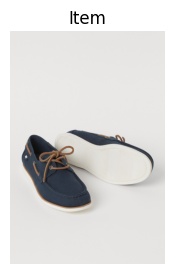

In [21]:
plot_items([article_id], ['Item'])

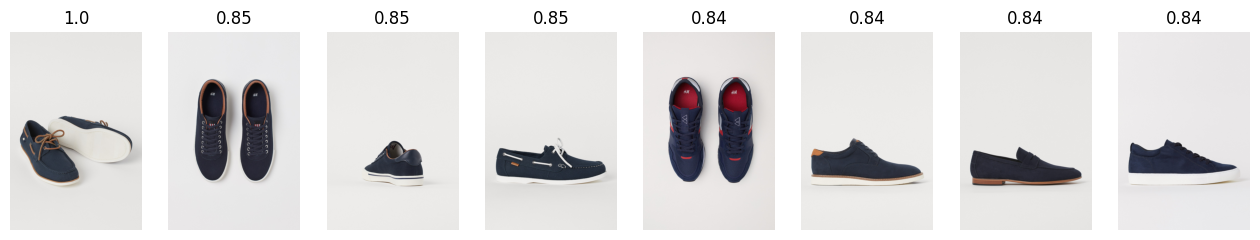

In [22]:
plot_items(combined_rcmnds, combined_scores)

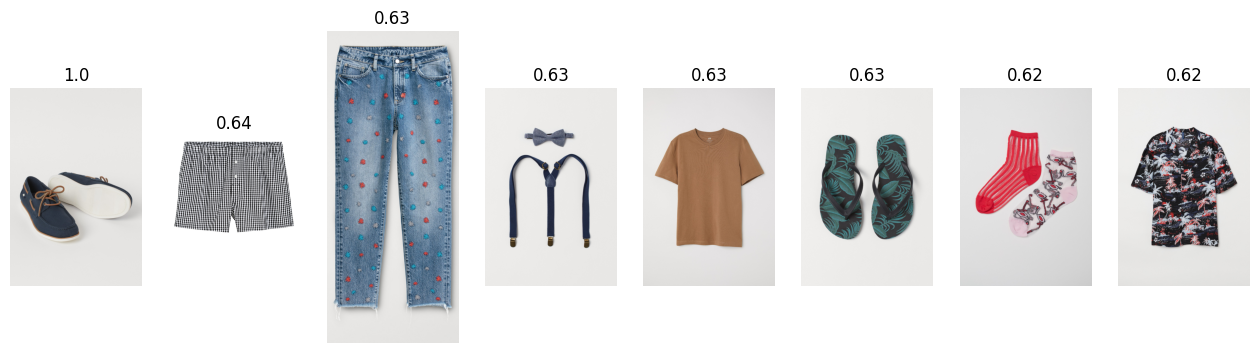

In [23]:
plot_items(image_rcmnds, image_scores)

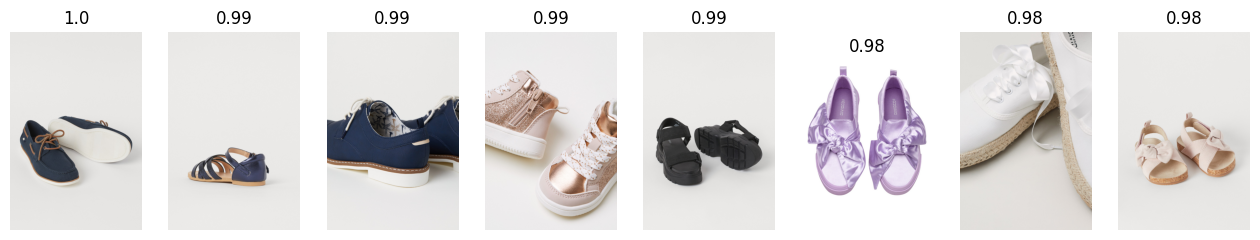

In [24]:
plot_items(tfrs_rcmnds, tfrs_scores)

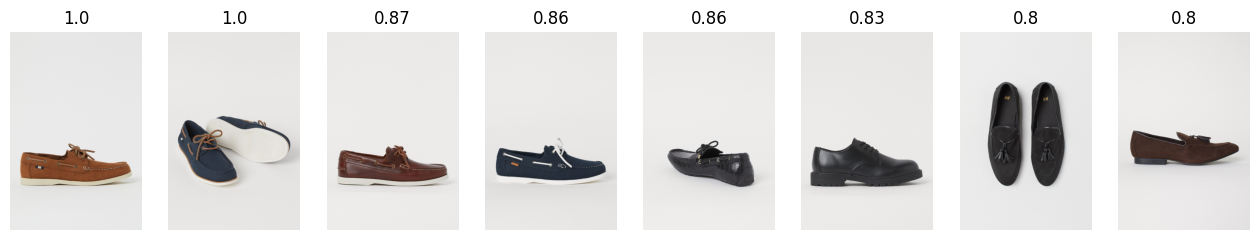

In [25]:
plot_items(text_rcmnds, text_scores)

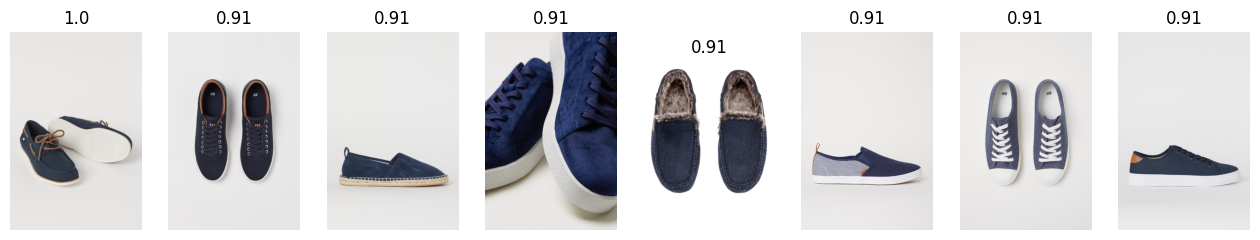

In [26]:
plot_items(feature_rcmnds, feature_scores)

Recommending Items For A Customer

In [54]:
customer = customer_all.sample(1).customer_id.values[0]
customer_history = eval(customers_history[customers_history.customer == customer].sequence.values[0])
customer_history = [int(i) for i in customer_history]

combined_customer, customer_tfrs, customer_image, customer_text, customer_feature = get_rand_customer(customer)
(combined_rcmnds, combined_scores), (image_rcmnds, image_scores), (tfrs_rcmnds, tfrs_scores), (text_rcmnds, text_scores), (feature_rcmnds, feature_scores) = get_rcmnds(combined_customer, customer_tfrs, customer_image, customer_text, customer_feature)

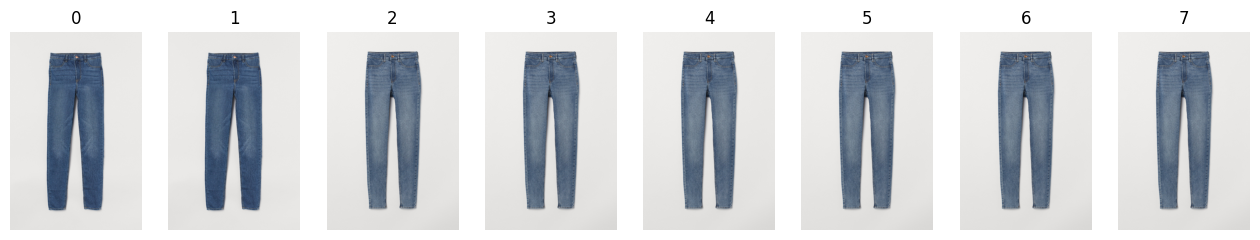

In [39]:
plot_items(customer_history[:8], range(8))

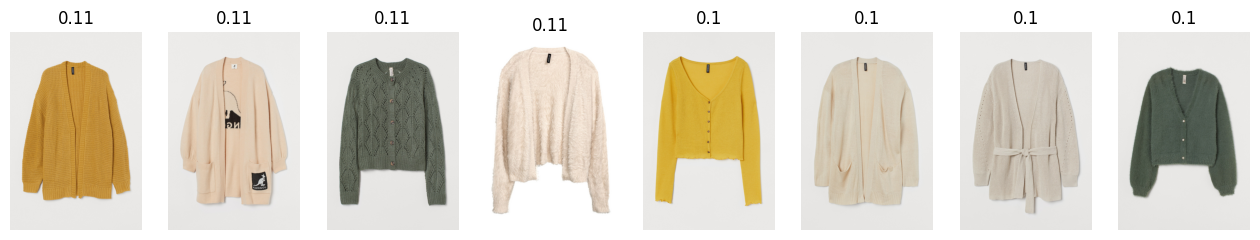

In [40]:
plot_items(combined_rcmnds, combined_scores)

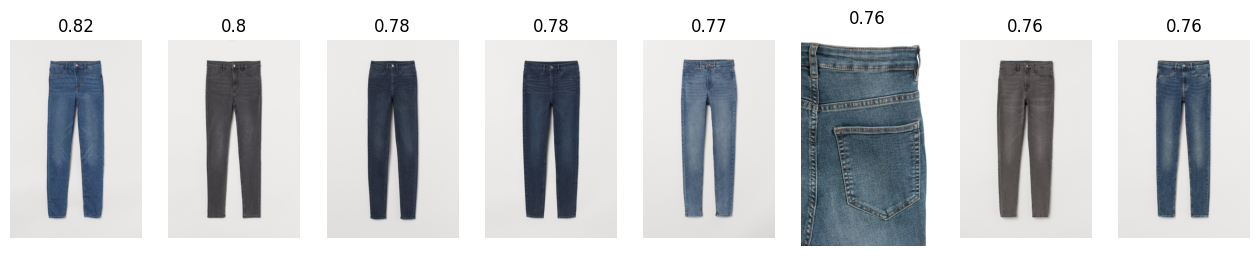

In [41]:
plot_items(image_rcmnds,image_scores)

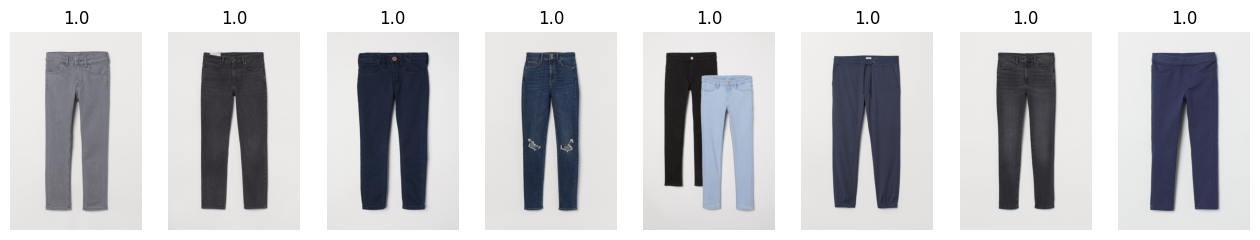

In [42]:
plot_items(tfrs_rcmnds, tfrs_scores)

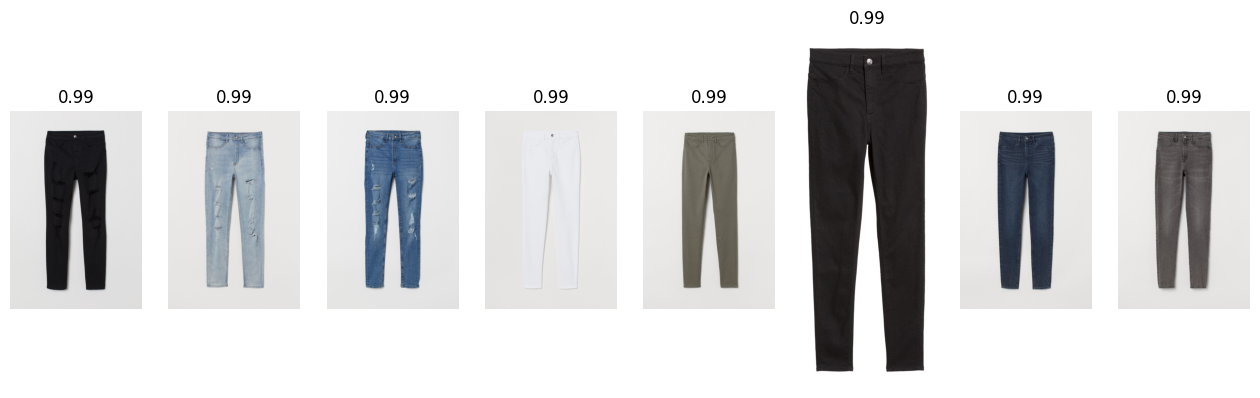

In [43]:
plot_items(text_rcmnds, text_scores)

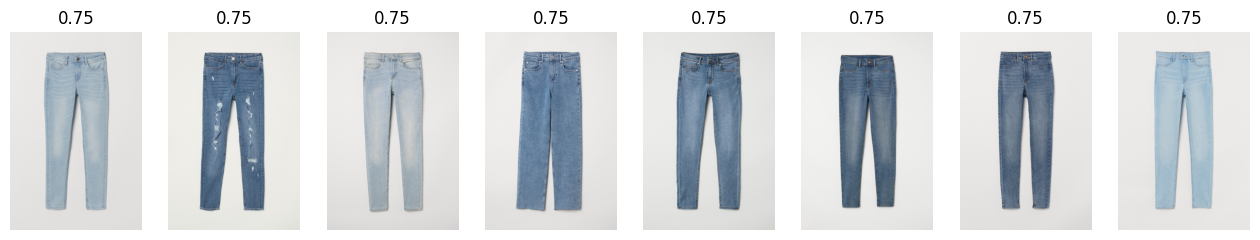

In [44]:
plot_items(feature_rcmnds, feature_scores)